In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
%matplotlib inline

In [2]:
#SI takes in a value and it's units, and returns the SI value equivalent
SI = lambda l, units : ((l * units).decompose()).value

#Constants:
T_test = 5730.97 #Kelvin
P_test = 1.2594 #log(P)
T_test_vega = 6744.1
P_test_vega = -0.027889772
B = 0.1 #ratio of the #He/#H
A = 10**4 #ratio of #H/#metal
sigma_t = 6.655*10**(-25) #cm^2 -- thompson
m_h = 1.6726219*10**(-24) #grams -- mass of ionized hydrogen, eg. a proton
c = SI(29979245800, u.cm/u.s) #cm / s -- speed of light 
h = 6.62606896*10**(-27) #ergs * s -- Planck's constant
k = 1.38065*10**(-16) #ergs / Kelvin -- Boltzmann constant
Chi = 2.195*10**(-11) #ergs -- ionization energy of hydrogen

#Constants for the sun-like star:
L = SI(5000, u.AA) #angstroms
l = ((L*u.m).to(u.micron)).value #microns
v = c/(L) # s^-1 -- frequency associated with L

#Constants for Vega:
L_vega = SI(7000, u.AA) #angstroms -- I will consider this wavelength for Vega
l_vega = ((L_vega*u.m).to(u.micron)).value
v_vega = c/(L_vega)

#input data - sun-like star:
check_ans = np.genfromtxt('opacities.dat', dtype='f8', names = ['temp', 'log_P', 'logH', 'logHminus', 'logsigma'])
temp_pelog_dat = np.genfromtxt('temp_pelog.dat', dtype='f8', names = ['temp','log_P' ])
temp = check_ans['temp']
pe_log = check_ans['log_P']

#ANSWERS for sun-like star opacities
check_H = check_ans['logH']
check_Hminus = check_ans['logHminus']
check_sigma = check_ans['logsigma']

#input data - vega:
opacities_vega = np.genfromtxt('vega-atmos-grid.dat', dtype='f8', names = ['temp', 'P'])
temp_vega = opacities_vega['temp']
p_vega = opacities_vega['P']

In [3]:
#Defining coefficients for a, b, c for the Gaunt bound-free factor
m = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
a_m = [0.9916, 1.105, 1.101, 0.9736, 1.03, 1.097, 1.098, 1., 1., 1.]
b_m = [0.09068, -0.7922, -0.329, 0., 0., 0., 0., 0., 0., 0.]
c_m = [-0.2524, 0.4536, 0.1152, 0., 0., 0., 0., 0, 0., 0.]

"""
Theta : Theta
Saha_H : Saha equation | hydrogen | Returns n/n ratio
Saha_metals : Saha equation | metals | Returns n/n ratio
X : X | fraction of ionized H
Y : Y | faction of ionized metal
Gaunt_ff : gaunt free-free factor
Gaunt_bf : gaunt bound-free factor
u : u, used in the absorption coefficient equation
"""

Theta = lambda T : 5040./T
Saha_H = lambda T, P : 10**((5.0/2.0)*np.log10(T) - 13.595*(Theta(T)) - P - 0.4772)
Saha_metals = lambda T, P : 10**((5.0/2.0)*np.log10(T) - 7.9*(Theta(T)) - P - 0.0971)
X = lambda H_ratio : H_ratio / (1 + H_ratio)
Y = lambda m_ratio : m_ratio / (1 + m_ratio)
Gaunt_ff = lambda T, l : 1.084 + 0.0188/Theta(T) + (0.00161 + (0.02661/Theta(T)))*l - (0.0192 - (0.03889/Theta(T)) + (0.02833/((Theta(T))**2)) - (0.007828/((Theta(T))**3)) + (0.0007304/((Theta(T))**4)))*(l**2)
Gaunt_bf = lambda l, m : a_m[m-1] + b_m[m-1]*l + c_m[m-1]*(l**2)
u = lambda T, m : (Chi/(k*T))/np.power(m, 2)

#Sun - H/m_ratio for X and Y
H_ratio = Saha_H(temp, pe_log)
m_ratio = Saha_metals(temp, pe_log)

#Vega - H/m_ratio for X and Y
H_ratio_vega = Saha_H(temp_vega, p_vega)
m_ratio_vega = Saha_metals(temp_vega, p_vega)

In [4]:
#Finding m_o and m_star - for the sun-like star and Vega.
test_m = (h * v) / (k*T_test)
for it_ in m:
    if test_m <= u(T_test,it_):
        print 'm: ',it_,'no'
        continue
    if test_m >= u(T_test,it_):
        m_0 = it_
        print 'm0:',m_0
        break
m_star =  m[9]

#Defining a new array of m's
new_m = np.arange(m_0, m_star + 1, 1)

#Building a function to sum over new_m's, for given temps.
def Summation(new_m,temp):
    summ = []
    for i in new_m:
        factor = Gaunt_bf(l, i) * (np.exp(u(temp, i))/(i**3))
        summ.append(factor)
    summ = np.array(summ)
    return np.sum(summ)

#Sun-like star - summation over new m's
summ = Summation(new_m,temp)
#Vega - summation over new m's
summ_vega = Summation(new_m,temp_vega)

#Atomic hydrogen absorption coefficient per neutral hydrogren: alpha_lambda
def neutral_H(summ,T,l,v,m_star):
    one = ((2.0898*10**(-14.))* (l**3) * np.exp(-1. * u(T,1))) * (1./2.)
    two = 1. - np.exp(-(h*v)/(k*T))
    three = (1./(2*u(T,1))) * (np.exp(u(T,m_star))) - 1. + Gaunt_ff(T,l)
    return one * two * (summ + three)

#mass absorption coefficient per gram - for the sun-like star
multiplier = (1.-X(H_ratio))/((1.+(4.*B))*m_h)
kappa_atomic = np.log10(neutral_H(summ, temp, l, v, m_star)*multiplier)

#mass absorption coefficient per gram - for Vega
multiplier_vega = (1.-X(H_ratio_vega))/((1.+(4.*B))*m_h)
kappa_atomic_vega = np.log10(neutral_H(summ_vega, temp_vega, l, v, m_star)*multiplier_vega)

m:  1 no
m:  2 no
m0: 3


In [5]:
#Defining k^* for a wavelength of 5000 Angstroms
k_star = 0.00680133 + 0.178708*(5.) + 0.164790*(5.**2) - 0.024842*(5.**3) + (5.**4)*5.95244*10**(-4)

#Bound-free absorption coefficient
absorp_bf = lambda P, T, v, k_star : (10.**(-26)) * (10.**P) * 0.4158*((Theta(T))**(5./2.)) * np.exp(1.726*(Theta(T))) * (1-np.exp((-h*v)/(k*T))) * k_star
#Free-free absorption coefficient
absorp_ff = lambda P, T, l : (10.**(-26)) * (10.**P) * (0.0053666 - 0.011493*(Theta(T)) + 0.027029*((Theta(T))**(2)) - (3.2062 - 11.924*(Theta(T)) + 5.939*((Theta(T))**(2)))*(l/(10**6)) - (0.40192 - 7.0355*(Theta(T)) + 0.34592*((Theta(T))**(2)))*((l**2)/(10**9)))

#ionized hydrogen absorption coefficient for the sun-like star 
absorp_H_neg = absorp_bf(pe_log, temp, v, k_star) + absorp_ff(pe_log, temp, l)
kappa_ion = np.log10(absorp_H_neg*multiplier)
kappa_total = kappa_atomic + kappa_ion

#ionized hydrogen absorption coefficient for Vega
absorp_H_neg_vega = absorp_bf(p_vega, temp_vega, v, k_star) + absorp_ff(p_vega, temp_vega, l)
kappa_ion_vega = np.log10(absorp_H_neg_vega*multiplier_vega)
kappa_total_vega = kappa_atomic_vega + kappa_ion_vega

In [6]:
#Calculating rayleigh scattering cross section, l is in angstroms | returns sigma_r_ans
cross_section_r = lambda l : (5.799*10**(-13))/(l**4) + 1.422*10**(-6)/(l**6) + 2.784/(l**8)

#Rayleigh scattering for the sun-like star
sigma_R_ang = cross_section_r(5000)*multiplier

#Rayleigh scattering for Vega
sigma_R_ang_vega = cross_section_r(5000)*multiplier_vega

In [7]:
#Calculating Thompson scattering for the sun-like star
sigma_T = sigma_t * ((X(H_ratio) + Y(m_ratio)/A)/((1.+4.*B)*m_h))

#Calculating total scattering for the sun-like star
sigma_total = sigma_R_ang + sigma_T

#Calculating Thompson scattering for Vega
sigma_T_vega = sigma_t * ((X(H_ratio_vega) + Y(m_ratio_vega)/A)/((1.+4.*B)*m_h))

#Calculating total scattering for Vega
sigma_total_vega = sigma_R_ang_vega + sigma_T_vega

In [8]:
#Writing and printing my values
f = open('my_answers.dat', 'w')
f_vega = open('my_answers_vega.dat','w')
write_kappa_atomic = kappa_atomic
write_kappa_ion = kappa_ion
write_sigma_total = np.log10(sigma_total)

write_kappa_atomic_vega = kappa_atomic_vega
write_kappa_ion_vega = kappa_ion_vega
write_sigma_total_vega = np.log10(sigma_total_vega)

for i in range(len(check_ans['temp'])):
    f.write(str(check_ans['temp'][i]) + ' ' + str(check_ans['log_P'][i]) + ' ' + str(write_kappa_atomic[i]) + ' ' + str(write_kappa_ion[i]) + ' ' + str(write_sigma_total[i]) + ' \n')
f.close()

for i in range(len(opacities_vega['temp'])):
    f_vega.write(str(opacities_vega['temp'][i]) + ' ' + str(opacities_vega['P'][i]) + ' ' + str(write_kappa_atomic_vega[i]) + ' ' + str(write_kappa_ion_vega[i]) + ' ' + str(write_sigma_total_vega[i]) + ' \n')
f_vega.close()


#For Sharelatex
latex = open('latex.dat', 'w')
for i in range(len(check_ans['temp'])):
    latex.write(str(check_ans['temp'][i]) + ' & ' + str(check_ans['log_P'][i]) + ' & ' + str(write_kappa_atomic[i]) + ' & ' + str(write_kappa_ion[i]) + ' & ' + str(write_sigma_total[i]) + '\\\ \n')
latex.close()

latex_vega = open('latex_vega.dat', 'w')
for i in range(len(opacities_vega['temp'])):
    latex_vega.write(str(opacities_vega['temp'][i]) + ' & ' + str(opacities_vega['P'][i]) + ' & ' + str(write_kappa_atomic_vega[i]) + ' & ' + str(write_kappa_ion_vega[i]) + ' & ' + str(write_sigma_total_vega[i]) + '\\\ \n')
latex_vega.close()

#Reading my answers in to print
my_ans = np.genfromtxt('my_answers.dat', dtype='f8', names = ['temp', 'log_P', 'logH', 'logHminus', 'logsigma'])

Neutral H err: 1.581743517
Ionized H err: -0.0208599034489
Sigma err:     -1.11636823467e-07


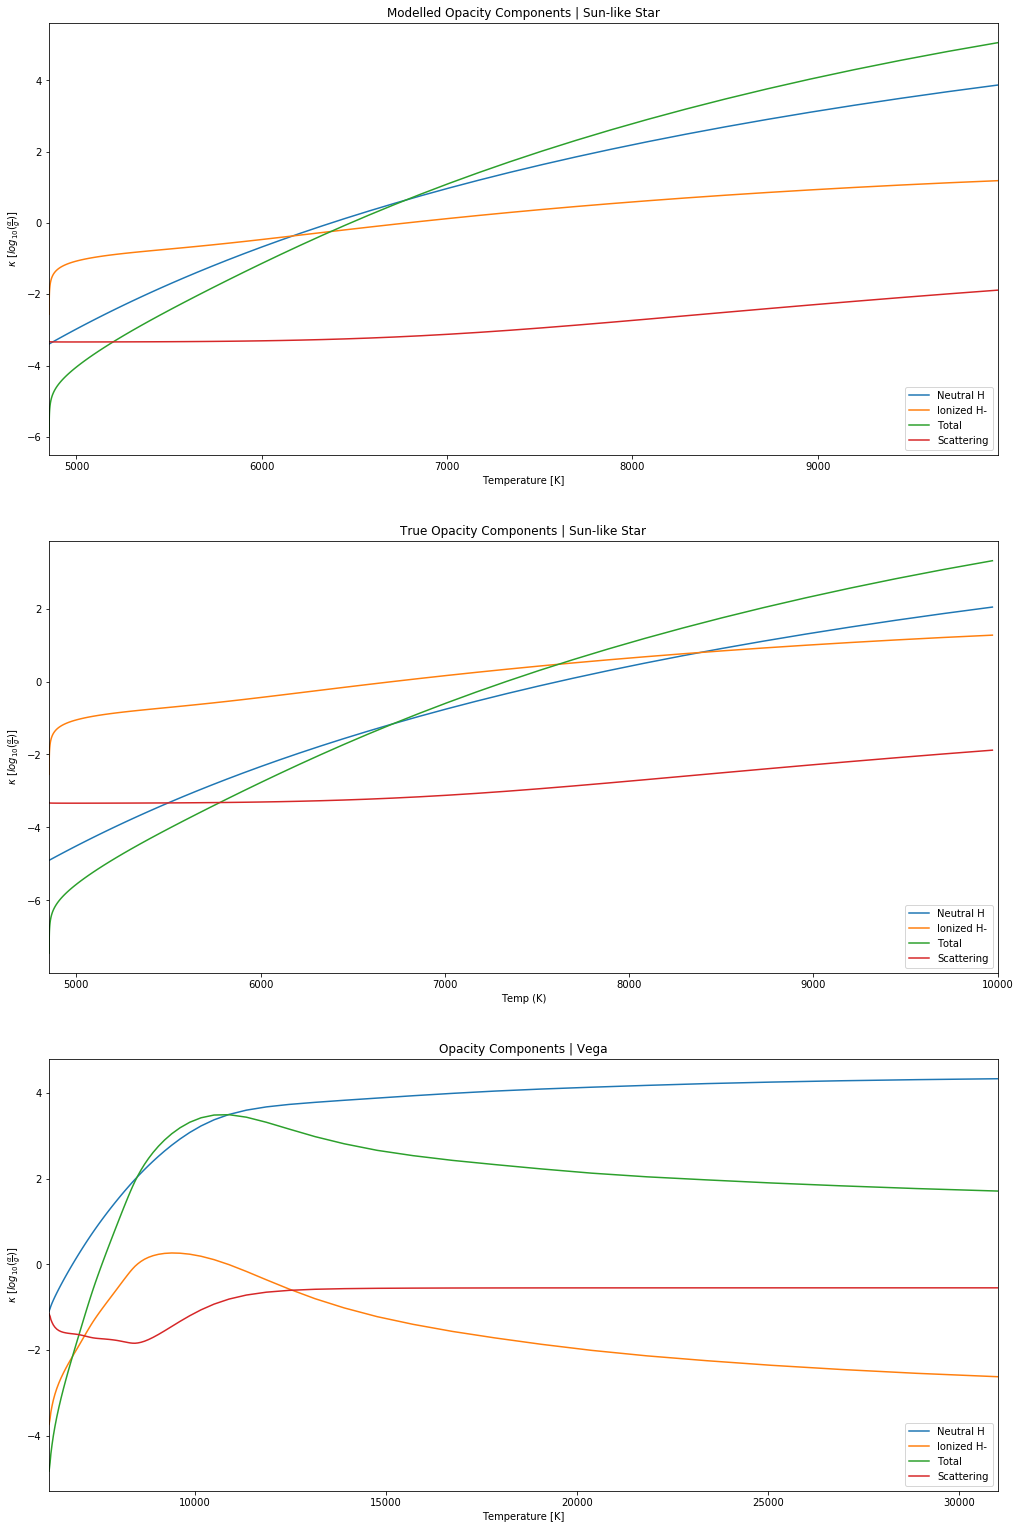

In [18]:
fig,ax = plt.subplots(3,1)
fig.set_size_inches(8.5*2,18*1.5)

#Opacity plots | sun-like star
ax[0].plot(temp, kappa_atomic, label = 'Neutral H');
ax[0].plot(temp, kappa_ion, label = 'Ionized H-');
ax[0].plot(temp, kappa_total, label = 'Total');
ax[0].plot(temp, np.log10(sigma_total), label = 'Scattering');
ax[0].set_xlim(np.min(temp), np.max(temp));
ax[0].legend(loc=4, prop={'size':10});
ax[0].set_xlabel('Temperature [K]');
ax[0].set_ylabel(r'$\kappa \,\, [log_{10}(\frac{\alpha}{g})]$');
ax[0].set_title('Modelled Opacity Components | Sun-like Star');

#Opacity plots | Vega
ax[2].plot(temp_vega, kappa_atomic_vega, label = 'Neutral H');
ax[2].plot(temp_vega, kappa_ion_vega, label = 'Ionized H-');
ax[2].plot(temp_vega, kappa_total_vega, label = 'Total');
ax[2].plot(temp_vega, np.log10(sigma_total_vega), label = 'Scattering');
ax[2].set_xlim(np.min(temp_vega), np.max(temp_vega));
ax[2].legend(loc=4, prop={'size':10});
ax[2].set_xlabel('Temperature [K]');
ax[2].set_ylabel(r'$\kappa \,\, [log_{10}(\frac{\alpha}{g})]$');
ax[2].set_title('Opacity Components | Vega');

#Opacity plots | official results
ax[1].plot(temp, check_H, label = 'Neutral H')
ax[1].plot(temp, check_Hminus, label = 'Ionized H-')
ax[1].plot(temp, check_H + check_Hminus, label = 'Total')
ax[1].plot(temp, check_sigma, label = 'Scattering')
ax[1].set_xlim(np.min(temp), 10000)
ax[1].legend(loc=4, prop={'size':10})
ax[1].set_xlabel('Temp (K)')
ax[1].set_ylabel(r'$\kappa \,\, [log_{10}(\frac{\alpha}{g})]$');
ax[1].set_title('True Opacity Components | Sun-like Star');

delta_H = kappa_atomic - check_H
delta_Hion = kappa_ion - check_Hminus
delta_sigma = np.log10(sigma_total) - check_sigma

#Error values
print 'Neutral H err:', np.sum(delta_H)/len(delta_H)
print 'Ionized H err:', np.sum(delta_Hion)/len(delta_Hion)
print 'Sigma err:    ', np.sum(delta_sigma)/len(delta_sigma)

fig.savefig('Opacity.png')